# Plots of differences
Based on the visualization technique of Joachim Goedhart:
https://github.com/JoachimGoedhart/PlotsOfDifferences

https://huygens.science.uva.nl/PlotsOfDifferences/

See also the blog post:
https://thenode.biologists.com/a-better-bar/education/


### First let's see the original version made with R

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= 'https://raw.githubusercontent.com/JoachimGoedhart/PlotsOfDifferences/master/DifferencesPlot_example1.png')


# Use it as a python module

In [2]:
from plots_of_differences import *

In [3]:
# Load Sample Dataframe
diff_df = pd.read_csv('PlotsOfDiffs_Tidy.csv')


In [4]:
plots_of_differences_plotly(diff_df, conditions_to_include=['wt','LARG','TIAM'])
    

Mean Effect Size for Each Condition Compared to Control:
The effect size for LARG compared with control is: -205.39604800000026
The effect size for TIAM compared with control is: 209.1895520000002
The effect size for wt compared with control is: 0.0


<Figure size 432x288 with 0 Axes>

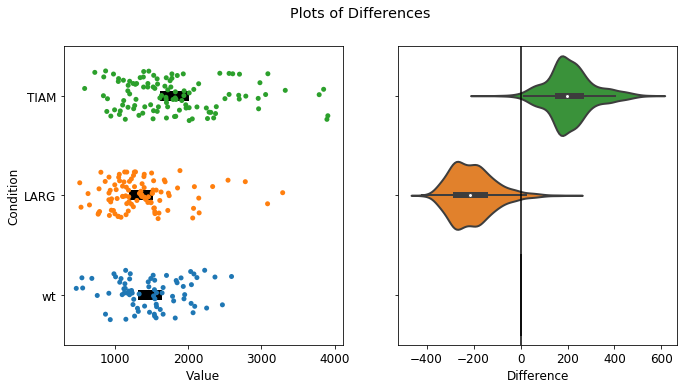

In [5]:
f = plots_of_differences_sns(diff_df,conditions_to_include=['wt','LARG','TIAM'])

# Or do it all directly in the notebook

In [6]:
import numpy as np
import pandas as pd
import os

import scipy
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from matplotlib import cm

# Plots Of Differences in Plotly:

In [7]:
# Bootstrapping function
def bootstrap_sample(df, n_samples=1000):
    
    measurements = df.values
    medians = []
    
    for i in range(n_samples): 
        
        samples = np.random.choice(measurements, size = len(measurements))
        medians.append(np.median(samples))

    medians = np.asarray(medians)

    return medians


In [8]:
def plots_of_differences_plotly(df_in,factor='Value', ctl_label = 'wt', palette='tab10', plot_type='swarm',conditions_to_include='all'):
    
    '''
    A function to create the plots of differences plots with bootstrapping CIs on sample data. 
    Based on the method and code from Joachim Goedhart doi: https://doi.org/10.1101/578575
        https://www.biorxiv.org/content/10.1101/578575v1.full.pdf+html
        and related code in R: 
        https://github.com/JoachimGoedhart/PlotsOfDifferences/blob/master/app.R
    '''
    
    df = df_in.copy()

    if ctl_label == -1:
        grouping = 'label'
        assert len(df[grouping].unique()) < 30, str(len(df[grouping].unique()))+ ' groups will be difficult to display, try optimizing the clustering.'

    else:
        
        grouping = 'Condition'

        if conditions_to_include  == 'all':
            conditions_to_include = df['Condition'].unique()

        # Sort the dataframe by custom category list to set draw order
        df[grouping] = pd.Categorical(df[grouping], conditions_to_include)


    df.sort_values(by=grouping, inplace=True, ascending=True)

    
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

    # Resize points based on number of samples to reduce overplotting.
    if(len(df) > 1000):
        pt_size = 1
    else:
        pt_size = 3


    # Get the control bootstrap

    # Get a colormap the length of unique condition (or whatever they're being grouped by)
    colors = np.asarray(sns.color_palette(palette, n_colors=len(pd.unique(df[grouping]))))

    ctl_bootstrap = bootstrap_sample(df[factor][df['Condition'] == ctl_label])

    # Store the calculated CIs in a list of shapes to add to the plot using shape in update layout.
    shape_list = []    

    for i in range(0,len(pd.unique(df[grouping]))):

        if (plot_type=='swarm'):

            # Plot the points
            fig.add_trace(go.Violin(
                                    # Select the subset of the dataframe we need by chaining another [] as condition to plot the susbset of the dataframe.
                                    x=df[factor][df[grouping] == pd.unique(df[grouping])[i]],
                                    y=df[grouping][df[grouping] == pd.unique(df[grouping])[i]],
                                    line={
                                        'width': 0
                                    },
                                    points="all",
                                    pointpos=0,
                                    marker={
                                         'color': 'rgb' + str(tuple(colors[i,:])),#colors[i],#'black' #diff_df['Value'].values
                                         'size': pt_size
                                         #'color': colors[np.where(cond_list == diff_df['Condition'])[0]]
                                    },
                                    orientation="h",
                                    jitter=1,
                                    fillcolor='rgba(0,0,0,0)',
                                    width= 0.75, # Width of the violin, will influence extent of jitter
                                   ),

                                    row=1, col=1)

        elif (plot_type=='violin'):

            # Plot the points
            fig.add_trace(go.Violin(
                                    # Select the subset of the dataframe we need by chaining another [] as condition to plot the susbset of the dataframe.
                                    x=df[factor][df[grouping] == pd.unique(df[grouping])[i]],
                                    y=df[grouping][df[grouping] == pd.unique(df[grouping])[i]],
                                    line={
                                        'width': 1
                                    },
                                    pointpos=0,
                                    marker={
                                         'color': 'rgb' + str(tuple(colors[i,:])),#colors[i],#'black' #diff_df['Value'].values
                                         'size': pt_size

                                    },
                                    orientation="h",
                                    side='positive',
                                    meanline_visible=True,
                                    points=False,
                                    width= 0.75, # Width of the violin, will influence extent of jitter
                                   ),

                                    row=1, col=1)

        elif (plot_type=='box'):

            # Plot the points
            fig.add_trace(go.Box(
                                # Select the subset of the dataframe we need by chaining another [] as condition to plot the susbset of the dataframe.
                                x=df[factor][df[grouping] == pd.unique(df[grouping])[i]],
                                y=df[grouping][df[grouping] == pd.unique(df[grouping])[i]],
                                line={
                                    'width': 1
                                },
#                                 pointpos=0,
                                marker={
                                     'color': 'rgb' + str(tuple(colors[i,:])),#colors[i],#'black' #diff_df['Value'].values
                                     'size': pt_size

                                },
                                orientation="h",
                                boxpoints='all',
                               ),

                                row=1, col=1)



        # Use the ctl_bootstrap if we're now on that condition, otherwise will create a new bootstrap sample that won't be the same.
        if(pd.unique(df['Condition'])[i] == ctl_label):
            bootstrap = ctl_bootstrap
        else:
            bootstrap = bootstrap_sample(df[factor][df['Condition'] == pd.unique(df['Condition'])[i]])

        difference = bootstrap - ctl_bootstrap

        # Calculate the confidence interval
        sample = df[factor][df['Condition'] == pd.unique(df['Condition'])[i]]
        raw_ci = st.t.interval(0.95, len(sample)-1, loc=np.mean(sample), scale=st.sem(sample))
        diff_ci = np.percentile(difference, [2.5,97.5])

        fig.add_trace(go.Violin(
                                # Select the subset of the dataframe we need by chaining another [] as condition to plot the susbset of the dataframe. 
                                x=difference,
                                y=df['Condition'][df['Condition'] == pd.unique(df['Condition'])[i]],    

                                side="positive",
                                orientation="h",
                                points=False,
                                # line_color = colors[i] #'black'
                                line_color = 'rgb' + str(tuple(colors[i,:])),#colors[i], #'black'

                               ), 
                                row=1, col=2)

 

        # Add raw CI to the list of dicts
        shape_list.append(dict(type="line", xref="x1", yref="y1",
                                 x0=raw_ci[0], y0=i, x1=raw_ci[1], y1=i, line_width=6))
        # Add diff CI to the list of dicts
        shape_list.append(dict(type="line", xref="x2", yref="y2",
                                 x0=diff_ci[0], y0=i, x1=diff_ci[1], y1=i, line_width=6))


    shape_list.append(dict(type="line", xref="x2", yref="y2",x0=0, y0=-1, x1=0, y1=3, line_width=2)) # Thick line at x=0 for the difference plot

    fig.update_layout(height=500, width=800,showlegend=False,
                      title_text="Plots of Differences",
                      shapes=shape_list # Accepts a list of dicts.
                     )
    fig.update_xaxes(title_text=factor, row=1, col=1)
    fig.update_xaxes(title_text="Difference", row=1, col=2)
    fig.show() 
    
# Test it:
diff_df = pd.read_csv('PlotsOfDiffs_Tidy.csv')
plots_of_differences_plotly(diff_df, conditions_to_include=['wt','LARG','TIAM'])
    

# Plots of differences in Seaborn

Mean Effect Size for Each Condition Compared to Control:
The effect size for LARG compared with control is: -198.67119999999989
The effect size for TIAM compared with control is: 215.9768000000002
The effect size for wt compared with control is: 0.0


<Figure size 432x288 with 0 Axes>

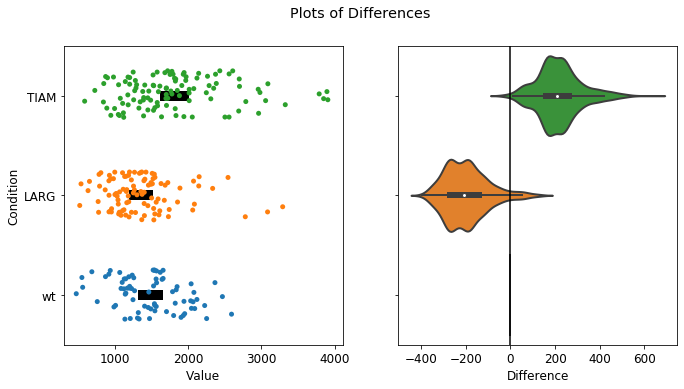

In [9]:
def plots_of_differences_sns(df_in, factor='Value', ctl_label = 'wt', conditions_to_include='all'):

    '''
    A function to create the plots of differences plots with bootstrapping CIs on sample data. 
    Based on the method and code from Joachim Goedhart doi: https://doi.org/10.1101/578575
        https://www.biorxiv.org/content/10.1101/578575v1.full.pdf+html
        and related code in R: 
        https://github.com/JoachimGoedhart/PlotsOfDifferences/blob/master/app.R
    '''
    
    plt.rcParams.update({'font.size': 12})
    plt.clf()

    assert ctl_label in df_in['Condition'].values, ctl_label + ' is not in the list of conditions'

    df = df_in.copy()
    
    if conditions_to_include  == 'all':
        conditions_to_include = df['Condition'].unique()

    # Sort values according to custom order for drawing plots onto graph
    df['Condition'] = pd.Categorical(df['Condition'], conditions_to_include)
    df.sort_values(by='Condition', inplace=True, ascending=True)

    bootstrap_diff_df = bootstrap_sample_df(df,factor,ctl_label)

    # Use Matplotlib to create subplot and set some properties
    fig_width = 11 # Inches
    aspect = 2

    fig, axes = plt.subplots(1, 2, figsize=(fig_width,fig_width/aspect))
    # plt.rcParams['savefig.facecolor'] = 'w'
    fig.suptitle('Plots of Differences')

    # Resize points based on number of samples to reduce overplotting.
    if(len(df) > 1000):
        pt_size = 1
    else:
        pt_size = 5

    #sns.swarmplot(ax=axes[0], x=factor, y="Condition",size=2, data=df)#, ax=g.ax) # Built with sns.swarmplot (no ci arg.)
    sns.stripplot(ax=axes[0], x=factor, y="Condition",size=pt_size,jitter=0.25, data=df)

    # Draw confidence intervalswith point plot onto scatter plot
    sns.pointplot(ax=axes[0], x=factor, y="Condition", data=df,color='black', ci = 95, join=False, errwidth=10.0) #calamansi kind="swarm",

    # Right subplot: differences

    sns.violinplot(ax=axes[1], x="Difference", y="Condition",kind="violin", inner='box', data=bootstrap_diff_df, split=True, ci = 'sd',linewidth=2)
    axes[1].axvline(0, ls='-', color='black')
    axes[1].set(ylabel=None)
    axes[1].set(yticklabels=[])

    # Invert both y axis to be consistent with original plots of difference
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()


    return fig

# test:
diff_df = pd.read_csv('PlotsOfDiffs_Tidy.csv')
f = plots_of_differences_sns(diff_df,conditions_to_include=['wt','LARG','TIAM'])

### From the preprint


'''Plotting the effect size

A bootstrap method is used to calculate the effect size and the compatibility interval (CI). To this
end, each condition is resampled 1000x with replacement to calculate a distribution of mean or
median values. 

A reference condition is selected by the user and the difference between the
collection of boostrapped median or mean values is calculated, resulting in a new distribution of
differences. This distribution is plotted. 

The 2.5th and 97.5th percentile of the distribution are used
to determine a 95% confidence interval around the difference. We will indicate this interval as
the compatibility interval (CI), i.e. the range of values most compatible with the data. The CI is
displayed as black line under the distribution.

The effect size plot is either displayed next to the data plot (landscape orientation) or below the
data plot (portrait orientation). Two file formats are available for downloading the figure, PDF
and PNG. The PNG format is lossless can be readily converted to other bitmap-type formats that
are suitable for presentation or incorporation into (multi-panel) figures
The PDF format is vectorbased and can be imported into any software package that handles vector-based graphics for
further adjustment of the lay-out'''